In [1]:
%cd ..
%matplotlib inline

/home/sandro/Projekte/2018_gait/gait_projects


In [8]:
import numpy as np
import cv2
import gait_analysis
from gait_analysis.data_preprocessing.preprocess import list_images, load_image
import os
from gait_analysis.utils.iterators import pairwise
from matplotlib import pyplot as plt
%matplotlib inline
sequence_folder = "/media/sandro/Volume/Datasets/tumgaid/TUMGAIDimage/image/p001/b01/"


In [9]:
def calc_of(prevs, _next):
    of = cv2.calcOpticalFlowFarneback(prevs, _next, None,
                                      pyr_scale=0.4,
                                      levels=1,
                                      winsize=12,
                                      iterations=2,
                                      poly_n=8,
                                      poly_sigma=1.2,
                                      flags=0)
    return of

In [15]:
def plot_flow(of):
    ofx, ofy = map(np.squeeze, np.split(of, 2, axis=-1))
    ofmagnitude = np.sqrt(ofx**2 + ofy**2)
    size_x, size_y = ofx.shape
    X, Y = np.meshgrid(np.arange(size_y), np.arange(size_x))
    U = ofx.copy()
    V = ofy.copy()
    
    spacing = 10
    X,Y,U,V = map( lambda x: x[::spacing, ::spacing], (X,Y,U,V))
    
    fig, ax = plt.subplots(frameon=False)
    ax.imshow(ofmagnitude)
    ax.set_axis_off()
    ax.quiver(X,Y,U,V, units='xy', scale=0.5)
    return fig, ax

In [16]:
output_folder = "/home/sandro/Projekte/2018_gait/slide_material/OR_2018_04_19/flow_frames/"
image_sequence = list_images(sequence_folder, 'jpg')

In [17]:
for i, frame_pair in enumerate(pairwise(image_sequence)):
    prev, _next = map(load_image, frame_pair)
    of = calc_of(prev, _next)
    fig, ax = plot_flow(of)
    fig.tight_layout()
    plt.savefig(os.path.join(output_folder, 'flow_{:03d}.png'.format(i)), pad_inches=0, dpi=200)
    plt.close()

In [18]:
pose_folder = "/media/sandro/Volume/Datasets/tumgaid/TUMGAIDimage_preprocessed/pose/p001/b01/"
import glob
from utils import openpose_utils
keypoint_files = sorted(glob.glob(os.path.join(pose_folder, "*.json")))
keypoint_file = keypoint_files[0]

ImportError: No module named utils

In [10]:
keypoints = openpose_utils.load_keypoints_from_file(keypoint_file)
pose = keypoints['people'][0]['pose_keypoints_2d']
pose_dict = openpose_utils.keypoints_to_posedict(pose)
body_keypoints_include_list = ['LAnkle', 'RAnkle', 'LKnee', 'RKnee', 'RHip', 'LHip']
reduced_keypoints = openpose_utils.filter_keypoints(pose_dict, body_keypoints_include_list)

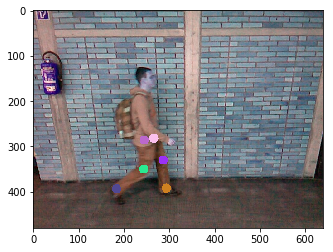

In [11]:
import cv2
from utils.openpose_utils import random_rgb
image_file = image_sequence[0]
im = cv2.imread(image_file)

for part, arr in reduced_keypoints.iteritems():
    # c is for confidence
    x, y, c = arr.astype(np.uint)
    r = 10
    im = cv2.circle(im, (x,y), r, random_rgb(), -1)
    
plt.imshow(im)

In [74]:
tumgaid_annotations_root = "/media/sandro/Volume/Datasets/tumgaid/annotations/"
import pandas as pd
import pyexcel as pe
import os
annotation_file = os.path.join(tumgaid_annotations_root, 'annotation_p001.ods')
sequence = 'b01'

def load_sequence_annotation(annotation_file, sequence):
    data = pe.get_dict(file_name=annotation_file,sheets=[sequence])
    df = pd.DataFrame(data)
    df = df.replace('', np.nan).dropna()
    df.frame_id = df.frame_id.astype(int)
    return df

def remove_nif(df):
    new_df = df[df.left_foot != 'NOT_IN_FRAME']
    new_df = df[df.right_foot != 'NOT_IN_FRAME']
    return new_df
    
def as_numeric(df):
    df.left_foot = 1.0 * (df.left_foot == "IN_THE_AIR")
    df.right_foot = 1.0 * (df.right_foot == "IN_THE_AIR")
    return df
    

df = load_sequence_annotation(annotation_file, sequence)
df = remove_nif(df)
df = as_numeric(df)

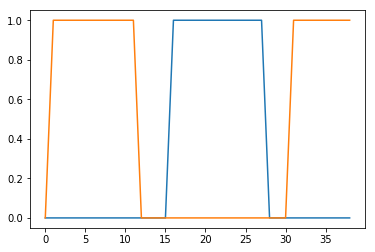

In [81]:
from matplotlib import pyplot as plt
plt.plot(df.frame_id, df.left_foot, label='left foot')
plt.plot(df.frame_id, df.right_foot, label='right foot')

In [41]:
from utils.iterators import pairwise
of_sequence = []
for i, frame_pair in enumerate(pairwise(image_sequence)):
    prev, _next = map(load_image, frame_pair)
    of = calc_of(prev, _next)
    of_sequence.append(of)

In [76]:
import glob
keypoint_files = sorted(glob.glob(os.path.join(pose_folder, "*.json")))


def pose_without_confidence(pose):
    return {key: arr[:1] for key, arr in pose.iteritems()}


def calc_pose_distance(pose1, pose2):
    pose1, pose2 = map(pose_without_confidence, [pose1, pose2])
    post_distance = {}
    for key in pose1.iterkeys():
        post_distance[key] = np.linalg.norm(pose1[key] - pose2[key])
    return post_distance
    


pose_sequence = {}
for i, pair in enumerate(pairwise(keypoint_files)):
    keypoints = map(openpose_utils.load_keypoints_from_file, pair)
    cur_people, next_people = [k['people'] for k in keypoints]
    if cur_people and next_people:
        poses = [p[0]['pose_keypoints_2d'] for p in [cur_people, next_people]]
        pose_dicts = map(openpose_utils.keypoints_to_posedict, poses)
        body_keypoints_include_list = ['LAnkle', 'RAnkle', 'LKnee', 'RKnee', 'RHip', 'LHip']
        pose_1, pose_2 = [openpose_utils.filter_keypoints(pose_dict, body_keypoints_include_list) 
                          for pose_dict in pose_dicts]
        pose_distance = calc_pose_distance(pose_1, pose_2)
        pose_sequence[i] = pose_distance
    else:
        pose_sequence[i] = {}

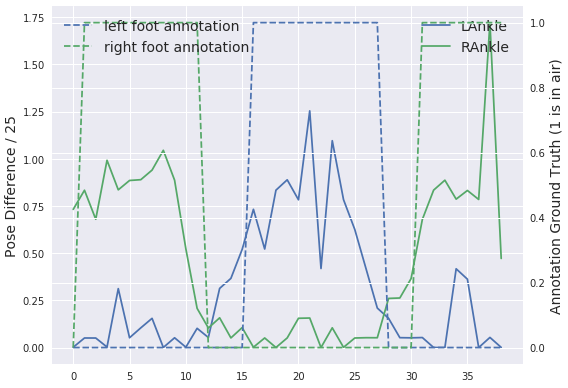

In [102]:
from itertools import cycle

linestyles = ['-', '--', '-.', ':']
linestyles = cycle(linestyles)
                     
with plt.style.context('seaborn'):

    keypoint_list = ['LAnkle', 'RAnkle']
    lst = linestyles.next()
    for keypoint in keypoint_list:
        keypoint_sequence = {i:pose_distance[keypoint] for i, pose_distance in pose_sequence.iteritems() if pose_distance}
        keypoint_sequence = {i:s for i,s in keypoint_sequence.iteritems() if i in df.frame_id}
        plt.plot(keypoint_sequence.keys(), np.array(keypoint_sequence.values())/25, 
                 label=keypoint, linestyle = lst)
        
    lst = linestyles.next()
    plt.legend(loc=1, fontsize=14)
    plt.ylabel("Pose Difference / 25", fontsize=14)    
    plt.twinx()
    plt.plot(df.frame_id, df.left_foot, label='left foot annotation', linestyle=lst)
    plt.plot(df.frame_id, df.right_foot, label='right foot annotation', linestyle=lst)
    plt.xlabel("frame_number", fontsize=14)
    plt.ylabel("Annotation Ground Truth (1 is in air)", fontsize=14)    
    
    
    plt.legend(loc=2, fontsize=14)
    plt.tight_layout()
    output_folder = "/home/sandro/Projekte/2018_gait/slide_material/OR_2018_04_19"
    plt.savefig(os.path.join(output_folder, 'pose_differences.png'), dpi=300)

48